In [1]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import osmnx # for handling data from OpenStreetMap (osm) with the help of networkX (nx)
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
import numpy as np
import helper
from sklearn.preprocessing import MinMaxScaler

In [25]:
df = pd.read_csv('data/preprocessed/combined.csv')
gdf_stations = helper.create_stations_gdf(df)
gdf_rides = helper.create_rides_gdf(df)

/Users/manuel/Documents/Semester 2/Geospatial Data Science/Exam_Project_Geospatial/helper.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides["geometry"] = df_rides.apply(


In [3]:
gdf_stations = gdf_stations.to_crs(epsg=3857)
gdf_rides = gdf_rides.to_crs(epsg=3857)

In [4]:
gdf_rides_sample = gdf_rides.sample(n=1000)

In [5]:
gdf_rides_sample.head(5)

,start_station_id,end_station_id,started_at,ended_at,duration,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_name,end_station_description,end_station_latitude,end_station_longitude,geometry
4844067,476,491,2022-05-14 16:50:06.372000+00:00,2022-05-14 17:07:49.417000+00:00,1063,Edvard Storms gate,ved Pilestredet,59.919111,10.736179,Brugata,ved Chr Kroghs gate,59.913661,10.757294,"LINESTRING (1195145.979 8381750.822, 1197496.4..."
4454563,537,421,2022-06-21 14:08:42.189000+00:00,2022-06-21 14:17:53.652000+00:00,551,St. Olavs gate,ved Pilestredet,59.917968,10.738629,Alexander Kiellands Plass,langs Maridalsveien,59.928067,10.751203,"LINESTRING (1195418.699 8381496.896, 1196818.4..."
7079044,380,744,2019-09-08 21:12:42.324000+00:00,2019-09-08 21:39:57.646000+00:00,1635,Bentsebrugata,rett over busstoppet,59.939230,10.759170,Hallénparken,ved Vogts gate,59.931530,10.762169,"LINESTRING (1197705.326 8386220.529, 1198039.1..."
4703135,483,2315,2022-11-03 06:51:29.254000+00:00,2022-11-03 06:56:32.211000+00:00,302,Hausmanns gate,ved Røde Kors,59.915451,10.758328,Rostockgata,utenfor Bjørvika visningssenter,59.906920,10.760312,"LINESTRING (1197611.595 8380937.995, 1197832.4..."
5125656,613,524,2022-10-20 16:26:20.314000+00:00,2022-10-20 16:32:39.223000+00:00,378,Schives gate,ved Arno Bergs plass,59.920956,10.714056,Volvat,langs Sørkedalsveien,59.933087,10.703968,"LINESTRING (1192683.217 8382160.679, 1191560.2..."


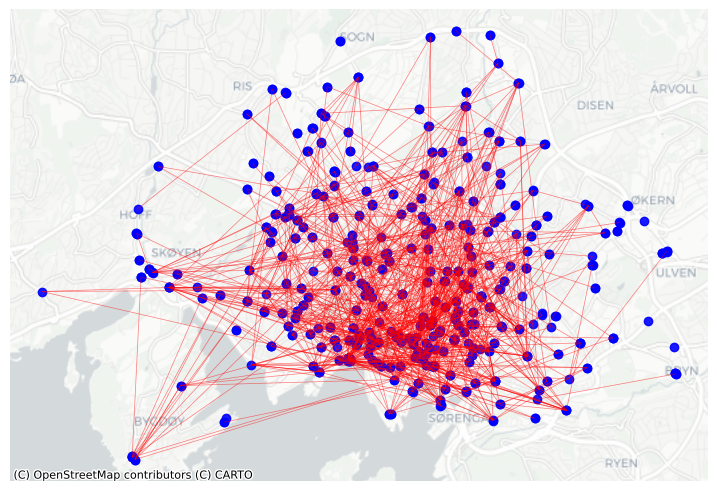

In [6]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_rides_sample.plot(linewidth= 0.5, alpha=0.5, ax=ax, color='red')
gdf_stations.plot(alpha=0.9, ax=ax, color='blue')
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf_stations.crs, source=cx.providers.CartoDB.Positron)

In [7]:
gdf_rides_unique = gdf_rides.drop_duplicates(subset=['start_station_id','end_station_id'])

In [8]:
len(gdf_rides_unique)

76712

In [9]:
rides_count =gdf_rides.groupby(['start_station_id', 'end_station_id'])['start_station_latitude'].count()

In [10]:
testdf = pd.DataFrame(data=rides_count.index, columns=['station_ids'])

In [11]:
testdf.head(5)

,station_ids
0,"(377, 377)"
1,"(377, 378)"
2,"(377, 380)"
3,"(377, 381)"
4,"(377, 382)"


In [12]:
testdf2 = pd.DataFrame(data=rides_count.values, columns=['count'])

In [13]:
testdf2.head(5)

,count
0,542
1,14
2,89
3,202
4,15


In [14]:
rides_count_df = pd.merge(testdf, testdf2, left_index=True, right_index=True)

In [15]:
rides_count_df.head(5)

,station_ids,count
0,"(377, 377)",542
1,"(377, 378)",14
2,"(377, 380)",89
3,"(377, 381)",202
4,"(377, 382)",15


In [16]:
rides_count_df[['start_station_id','end_station_id']] = rides_count_df.station_ids.apply( 
   lambda x: pd.Series(str(x).split(","))) 

In [17]:
rides_count_df['start_station_id'].str[1:]

0         377
1         377
2         377
3         377
4         377
         ... 
76707    4683
76708    4683
76709    4683
76710    4683
76711    4683
Name: start_station_id, Length: 76712, dtype: object

In [18]:
rides_count_df['start_station_id'] = rides_count_df['start_station_id'].str[1:]
rides_count_df['end_station_id'] = rides_count_df['end_station_id'].str.rstrip(')')

In [19]:
rides_count_df['start_station_id'] = pd.to_numeric(rides_count_df['start_station_id'])
rides_count_df['end_station_id'] = pd.to_numeric(rides_count_df['end_station_id'])

In [20]:
rides_count_df.dtypes

station_ids         object
count                int64
start_station_id     int64
end_station_id       int64
dtype: object

In [21]:
gdf_rides_unique_count = pd.merge(gdf_rides_unique, rides_count_df, 'inner',on=['start_station_id', 'end_station_id'])
gdf_rides_unique_count

,start_station_id,end_station_id,started_at,ended_at,duration,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_name,end_station_description,end_station_latitude,end_station_longitude,geometry,station_ids,count
0,507,2339,2023-10-01 00:00:40.773000+00:00,2023-10-01 00:04:34.682000+00:00,233,Jens Bjelkes Gate,ved Trondheimsveien,59.919147,10.764130,Elgsletta,langs Nylandsveien,59.915649,10.761725,"LINESTRING (1198257.424 8381758.913, 1197989.6...","(507, 2339)",140
1,607,393,2023-10-01 03:01:18.390000+00:00,2023-10-01 03:08:24.193000+00:00,425,Marcus Thranes gate,ved Akerselva,59.932772,10.758595,Hans Nielsen Hauges plass,langs Hans Nielsen Hauges gate,59.939244,10.774319,"LINESTRING (1197641.308 8384785.559, 1199391.7...","(607, 393)",110
2,500,506,2023-10-01 03:06:04.201000+00:00,2023-10-01 03:09:44.839000+00:00,220,Anker Hotel,langs Storgata,59.917279,10.758155,Botanisk Hage vest,ved Blytts gate,59.920128,10.768875,"LINESTRING (1197592.370 8381344.042, 1198785.7...","(500, 506)",188
3,599,600,2023-10-01 03:23:28.695000+00:00,2023-10-01 03:30:50.497000+00:00,441,Paléhaven,langs Strandgata,59.910331,10.750110,Dyvekes bru,ved skatepark,59.905323,10.768958,"LINESTRING (1196696.771 8379801.076, 1198794.9...","(599, 600)",673
4,597,568,2023-10-01 03:27:53.417000+00:00,2023-10-01 03:38:53.295000+00:00,659,Fredensborg,ved rundkjøringen,59.920995,10.750358,Frognerveien,ved Vestheimgata,59.917085,10.712880,"LINESTRING (1196724.378 8382169.263, 1192552.3...","(597, 568)",91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76707,484,618,2023-09-29 15:02:05.515000+00:00,2023-09-29 15:23:02.229000+00:00,1256,Karenslyst allé,ved Skabos vei,59.920330,10.683814,Bak Niels Treschows hus sør,nærmest trikkestopp,59.942473,10.723715,"LINESTRING (1189316.734 8382021.562, 1193758.5...","(484, 618)",1
76708,487,2350,2023-09-29 22:06:53.164000+00:00,2023-09-29 22:35:17.766000+00:00,1704,Carl Berners plass nord,ved Hasleveien,59.926929,10.776971,Blindern T-Bane,ved Blindernveien,59.940252,10.716724,"LINESTRING (1199686.924 8383487.374, 1192980.2...","(487, 2350)",1
76709,522,466,2023-09-30 07:52:06.881000+00:00,2023-09-30 08:06:24.853000+00:00,857,Mandalls gate,ved Grønlandsleiret,59.912347,10.763815,Ullevålsalléen,langs Sognsveien,59.937913,10.730480,"LINESTRING (1198222.371 8380248.695, 1194511.5...","(522, 466)",1
76710,2351,420,2023-09-30 10:02:50.978000+00:00,2023-09-30 10:13:25.436000+00:00,634,Sogn Studentby,Hjørnet av Sognsveien og Klaus Torgårds Vei,59.952084,10.727853,Bjølsendumpa,langs Treschows gate,59.940329,10.766137,"LINESTRING (1194219.110 8389077.730, 1198480.8...","(2351, 420)",1


In [22]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(np.array(list(gdf_rides_unique_count['count'])).reshape(-1, 1))
gdf_rides_unique_count_scaled = gdf_rides_unique_count.copy()
gdf_rides_unique_count_scaled['count'] = min_max_scaler.transform(np.array(list(gdf_rides_unique_count['count'])).reshape(-1, 1))

In [23]:
gdf_rides_unique_count_scaled['count']

0        0.019758
1        0.015494
2        0.026581
3        0.095522
4        0.012793
           ...   
76707    0.000000
76708    0.000000
76709    0.000000
76710    0.000000
76711    0.000000
Name: count, Length: 76712, dtype: float64

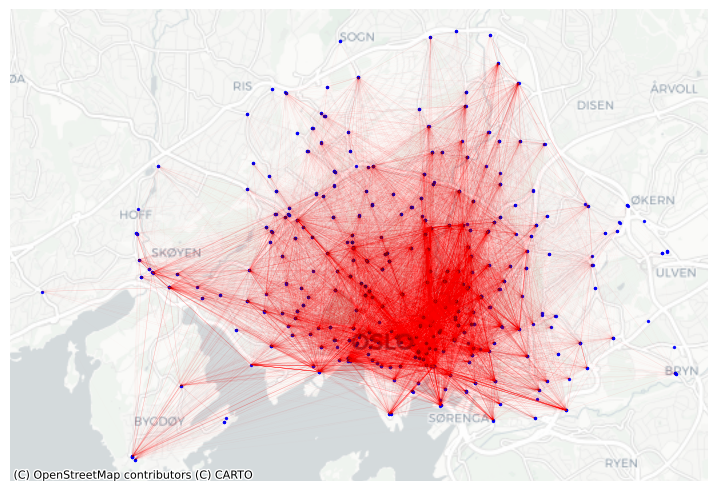

In [24]:
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_rides_unique_count_scaled.plot(linewidth= 0.3, alpha=gdf_rides_unique_count_scaled['count'], ax=ax, color='red')
gdf_stations.plot(alpha=0.9, markersize=2, ax=ax, color='blue')
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf_stations.crs, source=cx.providers.CartoDB.Positron)

#### Flow changes with expanding network

In [27]:
def createstationdf (df):
    # Create unique dataframes for start and end stations
    start_stations = df[['start_station_id', 'start_station_name', 'start_station_description', 'start_station_latitude', 'start_station_longitude', 'month', 'year']].drop_duplicates()
    end_stations = df[['end_station_id', 'end_station_name', 'end_station_description', 'end_station_latitude', 'end_station_longitude', 'month', 'year']].drop_duplicates()
    
    # Rename columns for uniformity
    start_stations.columns = ['station_id', 'station_name', 'station_description', 'latitude', 'longitude', 'month', 'year']
    end_stations.columns = ['station_id', 'station_name', 'station_description', 'latitude', 'longitude', 'month', 'year']
    
    # Concatenate the dataframes
    stations = pd.concat([start_stations, end_stations]).drop_duplicates()
    
    # Create GeoDataFrame
    gdf_stations = gpd.GeoDataFrame(
        stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude), crs = 4326
    )
    return gdf_stations

In [28]:
df = pd.read_csv('data/preprocessed/combined.csv')
gdf_station_year = createstationdf(df)

In [41]:
gdf_stations_2019 = gdf_station_year.loc[gdf_station_year['year'] == 19]
gdf_stations_2024 = gdf_station_year.loc[gdf_station_year['year'] == 24]
stations_2019 = gdf_stations_2019['station_id'].loc[gdf_stations_2019['year'] == 19].unique()
stations_2024 = gdf_stations_2024['station_id'].loc[gdf_stations_2024['year'] == 24].unique()
difference_19_24 = set(stations_2024) - set(stations_2019)
stations_change_2024_2019_df = gdf_stations_2024.loc[gdf_stations_2024['station_id'].isin(list(difference_19_24))]

In [44]:
difference_19_24

{428,
 487,
 1919,
 2270,
 2280,
 2304,
 2305,
 2306,
 2307,
 2308,
 2309,
 2315,
 2328,
 2329,
 2330,
 2332,
 2333,
 2334,
 2337,
 2339,
 2340,
 2347,
 2349,
 2350,
 2351,
 2355,
 2357,
 2358,
 3725,
 4552,
 4683}

In [58]:
rides_new_stations_start = gdf_rides.loc[gdf_rides['start_station_id'].isin(list(difference_19_24))]
rides_new_stations_end = gdf_rides.loc[gdf_rides['end_station_id'].isin(list(difference_19_24))]

In [59]:
frames = [rides_new_stations_start, rides_new_stations_end]
rides_new_stations = pd.concat(frames)

In [62]:
# Preprocessing
gdf_rides_unique_19_24 = rides_new_stations.drop_duplicates(subset=['start_station_id','end_station_id'])
rides_count_19_24 =rides_new_stations.groupby(['start_station_id', 'end_station_id'])['start_station_latitude'].count()
testdf_19_24 = pd.DataFrame(data=rides_count_19_24.index, columns=['station_ids'])
testdf2_19_24 = pd.DataFrame(data=rides_count_19_24.values, columns=['count'])
rides_count_19_24_df = pd.merge(testdf_19_24, testdf2_19_24, left_index=True, right_index=True)
rides_count_19_24_df[['start_station_id','end_station_id']] = rides_count_19_24_df.station_ids.apply( 
   lambda x: pd.Series(str(x).split(","))) 
rides_count_19_24_df['start_station_id'] = rides_count_19_24_df['start_station_id'].str[1:]
rides_count_19_24_df['end_station_id'] = rides_count_19_24_df['end_station_id'].str.rstrip(')')
rides_count_19_24_df['start_station_id'] = pd.to_numeric(rides_count_19_24_df['start_station_id'])
rides_count_19_24_df['end_station_id'] = pd.to_numeric(rides_count_19_24_df['end_station_id'])
gdf_rides_unique_count_19_24 = pd.merge(gdf_rides_unique_19_24, rides_count_19_24_df, 'inner',on=['start_station_id', 'end_station_id'])

In [63]:
min_max_scaler_19_24 = MinMaxScaler()
min_max_scaler_19_24.fit(np.array(list(gdf_rides_unique_count_19_24['count'])).reshape(-1, 1))
gdf_rides_unique_count_19_24_scaled = gdf_rides_unique_count_19_24.copy()
gdf_rides_unique_count_19_24_scaled['count'] = min_max_scaler_19_24.transform(np.array(list(gdf_rides_unique_count_19_24['count'])).reshape(-1, 1))

In [81]:
gdf_rides_unique_count_19_24_scaled = gdf_rides_unique_count_19_24_scaled.to_crs(epsg=3857)
gdf_stations_2024 = gdf_stations_2024.to_crs(epsg=3857)
gdf_stations_2019 = gdf_stations_2019.to_crs(epsg=3857)
stations_change_2024_2019_df = stations_change_2024_2019_df.to_crs(epsg=3857)

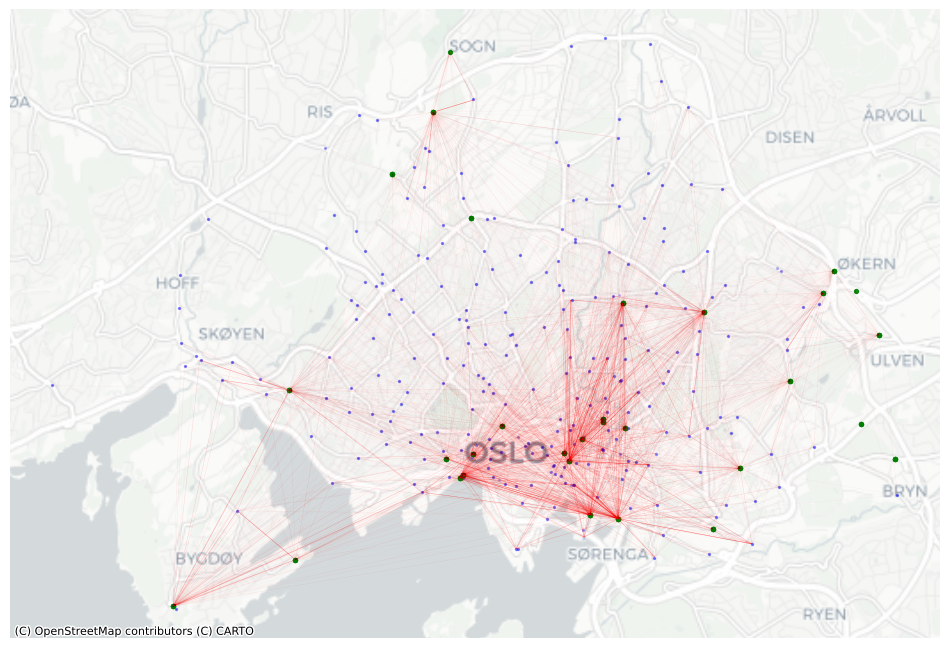

In [89]:
f, ax = plt.subplots(1, figsize=(12, 12))
gdf_rides_unique_count_19_24_scaled.plot(linewidth= 0.3, alpha=gdf_rides_unique_count_19_24_scaled['count'], ax=ax, color='red')
gdf_stations_2019.plot(alpha=0.05, markersize=2, ax=ax, color='blue')
stations_change_2024_2019_df.plot(alpha=0.9, markersize=8, ax=ax, color='green')
ax.set_axis_off()
cx.add_basemap(ax, crs=gdf_stations_2024.crs, source=cx.providers.CartoDB.Positron)